# Imports

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# from Neural_Networks import epochs, training_accurices, validation_accurices

# 1. Data preparation

### 1.1. Read data from file

In [33]:
#load the datasets (train data and test data which are pre-splitted)
data1 = MNIST(root='MNIST_dataset', train=True, download=True)
data2 = MNIST(root='MNIST_dataset', train=False, download=True)

#concatenate the data and labels from train and test datasets
all_images = torch.cat((data1.data, data2.data), dim=0)
all_labels = torch.cat((data1.targets, data2.targets), dim=0)

Now, we have 70,000 images intotal.

In [34]:
x = all_images.numpy()
y = all_labels.numpy()

print("Total images:", x.shape[0])

Total images: 70000


### 1.2. Normalizing the data

In [35]:
x = x / 255.0  # Normalize pixel values to [0, 1] range

print("min pixel value:", x.min(), ", max pixel value:", x.max())

min pixel value: 0.0 , max pixel value: 1.0


### 1.3. Splitting into train, validtaion and test sets

In [36]:
x_train, x_rest, y_train, y_rest = train_test_split(x, y, train_size= 0.6, random_state=42, stratify=y) # 60% train, 40% to split again into val and test
x_val, x_test, y_val, y_test = train_test_split(x_rest, y_rest, train_size=0.5, random_state=42, stratify=y_rest) # 40% * 50% = 20% val, 20% test

print("Training set = ", x_train.shape[0])
print("Validation set = ", x_val.shape[0])
print("Test set = ", x_test.shape[0])

Training set =  42000
Validation set =  14000
Test set =  14000


In [37]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Verify the new shape
print(f"Original shape: {x_train.shape}")
print(f"Flattened shape: {x_train_flat.shape}")

Original shape: (42000, 28, 28)
Flattened shape: (42000, 784)


### 1.4. Pytorch DataLoaders

In [38]:
# Change from numpy arrays to tensors
x_train_tensor = torch.from_numpy(x_train_flat).unsqueeze(1).float()
y_train_tensor = torch.from_numpy(y_train).long()

x_val_tensor = torch.from_numpy(x_val_flat).unsqueeze(1).float()
y_val_tensor = torch.from_numpy(y_val).long()

x_test_tensor = torch.from_numpy(x_test_flat).unsqueeze(1).float()
y_test_tensor = torch.from_numpy(y_test).long()

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders with batch size = 64 to optimize training
train_NN_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_NN_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_NN_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 2. Linear Classification Models

## 2.1. Logistic Regression

For logistic regression, it's a binary classifier, so we need to use two digits only as classes.

### 2.1.1. Data preparation For Binary Classification

Boolean masking is used to filter the dataset for two specific digits.

In [39]:
def filter_digits(x, y, digit1, digit2):
    filter_mask = (y == digit1) | (y == digit2)

    x_filtered = x[filter_mask]
    y_filtered = y[filter_mask]

    y_filtered = np.where(y_filtered == digit1, 0, 1) # Map digit1 to 0 and digit2 to 1
    return x_filtered, y_filtered

Filter the data for only 2 digits.

In [40]:
DIGIT_A = 0
DIGIT_B = 1

x_binary_train_flat, y_binary_train = filter_digits(x_train_flat, y_train, DIGIT_A, DIGIT_B)
x_binary_val_flat, y_binary_val = filter_digits(x_val_flat, y_val, DIGIT_A, DIGIT_B)
x_binary_test_flat, y_binary_test = filter_digits(x_test_flat, y_test, DIGIT_A, DIGIT_B)

In [41]:
print(x_binary_train_flat.shape, y_binary_train.shape)
print(x_binary_val_flat.shape, y_binary_val.shape)
print(x_binary_test_flat.shape, y_binary_test.shape)

(8868, 784) (8868,)
(2957, 784) (2957,)
(2955, 784) (2955,)


In [42]:
# Convert to float tensors
# Convert labels to columns vector
x_train_binary_tensor = torch.from_numpy(x_binary_train_flat).float()
y_train_binary_tensor = torch.from_numpy(y_binary_train).float().view(-1, 1)

x_val_binary_tensor = torch.from_numpy(x_binary_val_flat).float()
y_val_binary_tensor = torch.from_numpy(y_binary_val).float().view(-1, 1)

x_test_binary_tensor = torch.from_numpy(x_binary_test_flat).float()
y_test_binary_tensor = torch.from_numpy(y_binary_test).float().view(-1, 1)

train_binary_dataset = torch.utils.data.TensorDataset(x_train_binary_tensor, y_train_binary_tensor)
val_binary_dataset = torch.utils.data.TensorDataset(x_val_binary_tensor, y_val_binary_tensor)
test_binary_dataset = torch.utils.data.TensorDataset(x_test_binary_tensor, y_test_binary_tensor)

train_lr_loader = DataLoader(train_binary_dataset, batch_size=64, shuffle=True)
val_lr_loader = DataLoader(val_binary_dataset, batch_size=64, shuffle=False)
test_lr_loader = DataLoader(test_binary_dataset, batch_size=64, shuffle=False)

### 2.1.2. Defining The Model

In [43]:
INPUT_FEATURES = 784 # Number of pixels/inputs (28x28)
OUTPUT_FEATURES = 1  # The output is either 0 or 1

# Create the weights tensor of random numbers with size of (784, 1)
weights = torch.randn(INPUT_FEATURES, OUTPUT_FEATURES, dtype=torch.float)

# Create the bias tensor of zeros with size of 1 element
bias = torch.zeros(OUTPUT_FEATURES, dtype=torch.float)

# Enable gradient tracking for weights and bias
weights.requires_grad = True
bias.requires_grad = True

Define Sigmoid activation function and the cross entropy loss function.

In [44]:
def sigmoid(z):
    return 1.0 / (1.0 + torch.exp(-z))

# y_true are the labels (0 or 1) and y_pred_logits are the model outputs (logits)
def binary_cross_entropy_loss(y_true, y_pred_logits):

    p = sigmoid(y_pred_logits)
    
    # Prevent log(0) by adding a small value (epsilon)
    epsilon = 1e-7

    loss_per_item = - ( y_true * torch.log(p + epsilon) + (1.0 - y_true) * torch.log(1.0 - p + epsilon) )

    # Return average
    return torch.mean(loss_per_item)

### 2.1.3 Training The Model

In [45]:
learning_rate = 0.01
num_epochs = 100

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    correct, total, epoch_loss = 0,0,0

    for x_batch, y_batch in train_lr_loader:
        # Forward Pass
        logits = x_batch @ weights + bias

        loss = binary_cross_entropy_loss(y_batch, logits)
        loss.backward()

        with torch.no_grad():
            weights -= learning_rate * weights.grad
            bias -= learning_rate * bias.grad

        # Reset Gradients
        weights.grad.zero_()
        bias.grad.zero_()

        # Track Loss
        epoch_loss += loss.item() * x_batch.size(0)

        # Compute Accuracy
        predictions = (sigmoid(logits) >= 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += x_batch.size(0)

    train_losses.append(epoch_loss / total)
    train_accuracies.append(correct / total)

    # Validation
    with torch.no_grad():
        val_logits = x_val_binary_tensor @ weights + bias
        val_predictions = sigmoid(val_logits)
        val_loss = binary_cross_entropy_loss(y_val_binary_tensor, val_logits)
        val_losses.append(val_loss.item())

        val_pred_labels = (val_predictions >= 0.5).float()
        val_accuracy = (val_pred_labels == y_val_binary_tensor).float().mean().item()
        val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]*100:.2f}% | "
          f"Val Acc: {val_accuracies[-1]*100:.2f}%")

Epoch 1/100 | Train Loss: 1.3192 | Train Acc: 71.57% | Val Acc: 82.69%
Epoch 2/100 | Train Loss: 0.4440 | Train Acc: 87.51% | Val Acc: 91.51%
Epoch 3/100 | Train Loss: 0.2697 | Train Acc: 92.69% | Val Acc: 93.74%
Epoch 4/100 | Train Loss: 0.1997 | Train Acc: 94.46% | Val Acc: 94.76%
Epoch 5/100 | Train Loss: 0.1621 | Train Acc: 95.61% | Val Acc: 95.67%
Epoch 6/100 | Train Loss: 0.1386 | Train Acc: 96.15% | Val Acc: 96.14%
Epoch 7/100 | Train Loss: 0.1223 | Train Acc: 96.54% | Val Acc: 96.75%
Epoch 8/100 | Train Loss: 0.1104 | Train Acc: 97.10% | Val Acc: 97.16%
Epoch 9/100 | Train Loss: 0.1012 | Train Acc: 97.35% | Val Acc: 97.19%
Epoch 10/100 | Train Loss: 0.0939 | Train Acc: 97.56% | Val Acc: 97.53%
Epoch 11/100 | Train Loss: 0.0879 | Train Acc: 97.70% | Val Acc: 97.73%
Epoch 12/100 | Train Loss: 0.0829 | Train Acc: 97.85% | Val Acc: 97.73%
Epoch 13/100 | Train Loss: 0.0786 | Train Acc: 97.90% | Val Acc: 97.97%
Epoch 14/100 | Train Loss: 0.0748 | Train Acc: 98.07% | Val Acc: 98.07%
E

### 2.1.4 Loss & Accuracy Curves for Training and Validation


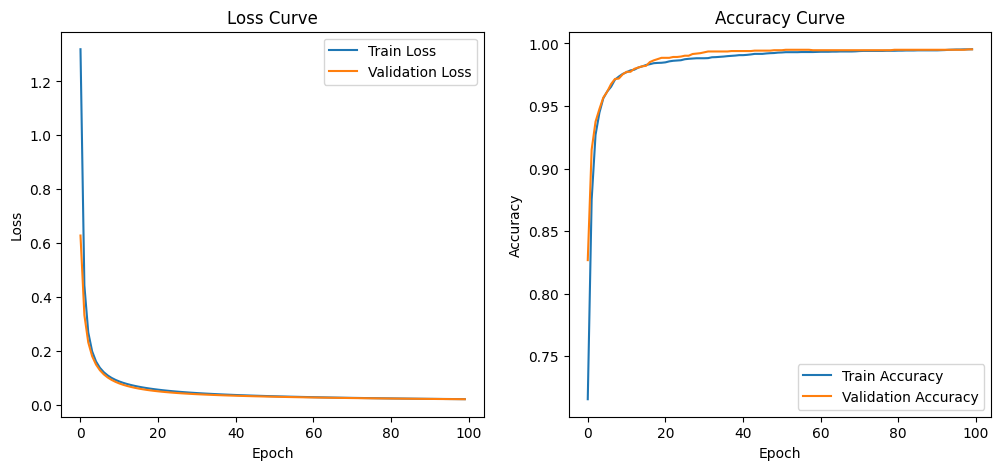

In [46]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

### 2.1.5 Test Accuracy & Confusion Matrix


Test Accuracy: 99.46%


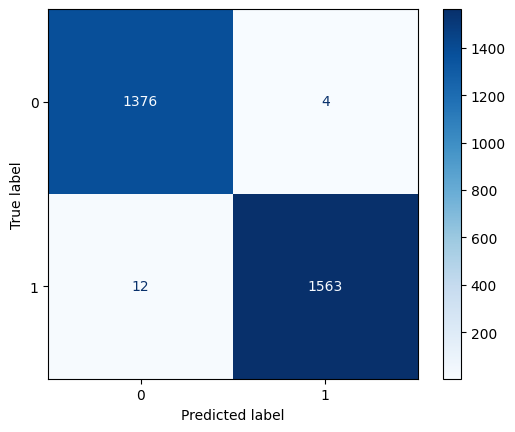

In [47]:
with torch.no_grad():
    test_logits = x_test_binary_tensor @ weights + bias
    test_predictions = (sigmoid(test_logits) >= 0.5).float()

test_accuracy = (test_predictions == y_test_binary_tensor).float().mean().item()
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

cm = confusion_matrix(y_test_binary_tensor.numpy(), test_predictions.numpy())
ConfusionMatrixDisplay(cm, display_labels=[DIGIT_A, DIGIT_B]).plot(cmap="Blues")
plt.show()